After confirm that our implementation is OK, now we want to test the performance (velocity) of the different usages (with and without) analytical models.

In [4]:
import autolens as al
import autolens.plot as aplt
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import z_at_value
from astropy.cosmology import Planck15 as cosmo
import time

In [2]:
grid = al.Grid.uniform(shape_2d=(80, 80), pixel_scales=0.09, sub_size=1)

In [3]:
#Reading MGE inputs
surf_lum, sigma_lum, qobs_lum = np.loadtxt("JAM_Input.txt", unpack=True)           #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("SphNFW_2e3arcsec.txt", unpack=True)     #DM component

In [6]:
#Input
#Only for lensing modelling 
z_l    = 0.299                                                         #Lens Redshift
z_s    = 3.100                                                         #Source Redshift 
D_l    = cosmo.angular_diameter_distance(z_l).value                    #Distance to lens [Mpc] 
mbh    = 1e9                                                           #mass of black hole [log10(M_sun)]
kappa_ = 1.00                                                          #kappa_s of DM halo
r_s    = 11.5                                                          #scale radius os dm halo
ml     = 7.7                                                           #mass to light ratio
shear_comp = al.convert.shear_elliptical_comps_from(magnitude=0.02, phi=88) #external shear

# Only MGE parametrization

In [7]:
#Initializing
mass_profile_MGE = al.mp.MGE()


#Components
mass_profile_MGE.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml,
                       mbh=mbh, surf_dm=kappa_*surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [8]:
#One run to start Jit functions and don't impact down the real time.
star_jit = mass_profile_MGE.deflections_from_grid(grid)

In [13]:
n = 1000
time_MGE = np.empty(n)
for i in range(n):
    start = time.time()
    mass_profile_MGE.deflections_from_grid(grid)
    time_MGE[i] = time.time() - start

# Both profiles

In [15]:
#Initializing
mass_profile_BOTH = al.mp.MGE()

#Analytical DM
sNFW = al.mp.dark_mass_profiles.SphericalNFW(kappa_s=kappa_, scale_radius=r_s)                

#Components of MGE, only stars
mass_profile_BOTH.MGE_comps(z_l=z_l, z_s=z_s, 
                       surf_lum=surf_lum, sigma_lum=sigma_lum, qobs_lum=qobs_lum, ml=ml, mbh=mbh)

#Including analytic model for DM
mass_profile_BOTH.Analytic_Model(analytic_profile=sNFW)

In [16]:
#One run to start Jit functions and don't impact down the real time.
star_jit = mass_profile_BOTH.deflections_from_grid(grid)

In [18]:
n = 1000
time_BOTH = np.empty(n)
for i in range(n):
    start = time.time()
    mass_profile_BOTH.deflections_from_grid(grid)
    time_BOTH[i] = time.time() - start

In [21]:
np.savetxt("Time.txt", np.column_stack([time_MGE, time_BOTH]), header="MGE Time (s) \t BOTH Time (s)",
                          fmt="%.4e \t\t %.4e")

# PLoting Time for CHE tests

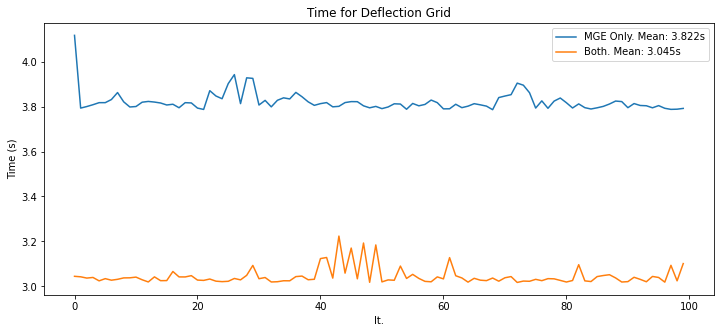

In [29]:
time_MGE, time_BOTH = np.loadtxt("Time_CHE.txt", unpack=True)

plt.figure(figsize=(12,5))
plt.plot(time_MGE, label="MGE Only. Mean: %.3fs"%np.mean(time_MGE))
plt.plot(time_BOTH, label="Both. Mean: %.3fs"%np.mean(time_BOTH))
plt.title("Time for Deflection Grid")
plt.xlabel("It.")
plt.ylabel("Time (s)")
plt.legend()